In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.use_deterministic_algorithms(True)


def load_data_new(seed):
    X_data_train = pd.read_csv('/content/drive/MyDrive/CaReTS/prs_HWM_train.csv')
    Y_data_train = X_data_train

    X_train_full = X_data_train.iloc[:, 0:15].values
    y_train_full = Y_data_train.iloc[:, 15:21].values

    X_train_time = X_train_full[:, :3].astype(np.float32)
    X_train_seq = X_train_full[:, 3:].astype(np.float32)

    X_train_time[:, 0] /= 23.0
    X_train_time[:, 1] /= 7.0
    X_train_time[:, 2] /= 12.0

    X_seq_min, X_seq_max = X_train_seq.min(axis=0), X_train_seq.max(axis=0)
    y_min, y_max = y_train_full.min(axis=0), y_train_full.max(axis=0)

    X_train_seq_scaled = (X_train_seq - X_seq_min) / (X_seq_max - X_seq_min + 1e-8)
    y_train_scaled = (y_train_full - y_min) / (y_max - y_min + 1e-8)

    X_train_combined = np.concatenate([X_train_time, X_train_seq_scaled], axis=1)

    trend_labels = (y_train_full > X_train_seq[:, -1].reshape(-1, 1)).astype(int)

    X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).unsqueeze(-1)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    trend_tensor = torch.tensor(trend_labels, dtype=torch.long)

    dataset = TensorDataset(X_train_tensor, y_train_tensor, trend_tensor)


    X_data_test = pd.read_csv('/content/drive/MyDrive/CaReTS/prs_HWM_test.csv')
    Y_data_test = X_data_test

    X_test_full = X_data_test.iloc[:, 0:15].values
    y_test_full = Y_data_test.iloc[:, 15:21].values

    X_test_time = X_test_full[:, :3].astype(np.float32)
    X_test_seq = X_test_full[:, 3:].astype(np.float32)

    X_test_time[:, 0] /= 23.0
    X_test_time[:, 1] /= 7.0
    X_test_time[:, 2] /= 12.0

    X_test_seq_scaled = (X_test_seq - X_seq_min) / (X_seq_max - X_seq_min + 1e-8)
    y_test_scaled = (y_test_full - y_min) / (y_max - y_min + 1e-8)

    X_test_combined = np.concatenate([X_test_time, X_test_seq_scaled], axis=1)

    trend_labels_test = (y_test_full > X_test_seq[:, -1].reshape(-1, 1)).astype(int)

    X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32).unsqueeze(-1)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
    trend_test_tensor = torch.tensor(trend_labels_test, dtype=torch.long)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor, trend_test_tensor)

    return dataset, test_dataset, (X_seq_min, X_seq_max, y_min, y_max)


class RegressionDualBranchModel(nn.Module):
    # def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_len=6, model_type='LSTM'):#
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_len=6, model_type='CNN'):#
    # def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_len=6, model_type='TRANSFORMER'):#
        super().__init__()
        self.output_len = output_len
        self.model_type = model_type.upper()

        if self.model_type == 'LSTM':
            self.feature_extractor = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        elif self.model_type == 'CNN':
            self.feature_extractor = nn.Sequential(
                nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(32, hidden_dim, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1)  # Output shape：[B, hidden_dim, 1]
            )

        elif self.model_type == 'TRANSFORMER':
            self.input_projection = nn.Linear(input_dim, hidden_dim)

            self.pos_embedding = nn.Parameter(torch.randn(1, 25, hidden_dim))  # Maximum sequence length
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, batch_first=True)
            self.feature_extractor = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        else:
            raise ValueError(f"Unknown type: {self.model_type}")

        # self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.branch1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.branch2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fusion = nn.Linear(2 * hidden_dim, output_len)

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        if self.model_type == 'LSTM':
            out, _ = self.feature_extractor(x)
            h = out[:, -1, :]  # [B, hidden_dim]

        elif self.model_type == 'CNN':
            # CNN expects input: [B, input_dim, seq_len]
            x_cnn = x.permute(0, 2, 1)
            out = self.feature_extractor(x_cnn)  # [B, hidden_dim, 1]
            h = out.squeeze(-1)  # [B, hidden_dim]

        elif self.model_type == 'TRANSFORMER':
            x_proj = self.input_projection(x)  # [B, seq_len, hidden_dim]
            seq_len = x_proj.size(1)
            pos_embed = self.pos_embedding[:, :seq_len, :]
            x_proj = x_proj + pos_embed
            out = self.feature_extractor(x_proj)
            h = out[:, -1, :]

        else:
            raise ValueError("Unsupported type")

        b1 = self.branch1(h)
        b2 = self.branch2(h)

        h_cat = torch.cat([b1, b2], dim=1)
        y_pred = self.fusion(h_cat)

        return y_pred


def evaluate_model(model, data_loader, y_min, y_max):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X_batch, y_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred_scaled = model(X_batch)
            preds.append(y_pred_scaled.cpu().numpy())
            trues.append(y_batch.cpu().numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    y_pred = preds * (y_max - y_min + 1e-8) + y_min
    y_true = trues * (y_max - y_min + 1e-8) + y_min
    mse_per_output = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    mse_total = np.mean(mse_per_output)
    rmse_total = np.sqrt(mse_total)
    return mse_per_output, mse_total, rmse_total, y_true, y_pred



Using device: cpu


In [3]:
# ==================== Mian Training ====================
num_folds = 10
num_epochs = 600
batch_size = 64
base_seed = 2025

full_dataset, test_dataset, (X_min, X_max, y_min, y_max) = load_data_new(seed=base_seed)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

kf = KFold(n_splits=num_folds, shuffle=True, random_state=base_seed)

train_mse_all, val_mse_all, train_rmse_all, val_rmse_all = [], [], [], []
test_mse_per_output_all, test_mse_total_all, test_rmse_total_all = [], [], []
train_mse_per_epoch_all, val_mse_per_epoch_all = [], []


for fold_idx, (train_idx, val_idx) in enumerate(kf.split(range(len(full_dataset))), 1):
    print(f"\n=== Fold {fold_idx}/{num_folds} ===")
    set_seed(base_seed + fold_idx)

    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = RegressionDualBranchModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    counter = 0
    patience = 75

    train_mse_per_epoch, val_mse_per_epoch = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch, _ in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        avg_train_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                mse = loss_fn(y_pred, y_batch)
                val_loss += mse.item() * X_batch.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)

        train_mse_per_epoch.append(avg_train_loss)
        val_mse_per_epoch.append(avg_val_loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1} | Train MSE: {avg_train_loss:.6f} | Val MSE: {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    train_mse_per_epoch_all.append(train_mse_per_epoch)
    val_mse_per_epoch_all.append(val_mse_per_epoch)

    model.load_state_dict(best_model_state)

    def get_final_mse(loader):
        model.eval()
        total = 0
        with torch.no_grad():
            for X_batch, y_batch, _ in loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(X_batch)
                mse = loss_fn(pred, y_batch)
                total += mse.item() * X_batch.size(0)
        return total / len(loader.dataset)

    train_mse = get_final_mse(train_loader)
    val_mse = get_final_mse(val_loader)
    train_rmse = np.sqrt(train_mse)
    val_rmse = np.sqrt(val_mse)

    mse_per_output, mse_total, rmse_total, y_true, y_pred = evaluate_model(model, test_loader, y_min, y_max)

    train_mse_all.append(train_mse)
    val_mse_all.append(val_mse)
    train_rmse_all.append(train_rmse)
    val_rmse_all.append(val_rmse)
    test_mse_per_output_all.append(mse_per_output)
    test_mse_total_all.append(mse_total)
    test_rmse_total_all.append(rmse_total)

    if fold_idx == num_folds:
        y_true_test_final = y_true
        y_pred_test_final = y_pred
        last_train_losses = train_mse_per_epoch
        last_val_losses = val_mse_per_epoch

    print(f"Fold {fold_idx} - Train RMSE: {train_rmse:.6f} | Val RMSE: {val_rmse:.6f} | Test RMSE: {rmse_total:.6f}")

# === Final Summary ===
print("\n=== Final Results (mean ± std over folds) ===")
print(f"Train RMSE: {np.mean(train_rmse_all):.6f} ± {np.std(train_rmse_all):.6f}")
print(f"Val   RMSE: {np.mean(val_rmse_all):.6f} ± {np.std(val_rmse_all):.6f}")
print(f"Test  RMSE: {np.mean(test_rmse_total_all):.6f} ± {np.std(test_rmse_total_all):.6f}")


=== Fold 1/10 ===
Epoch 1 | Train MSE: 0.034999 | Val MSE: 0.024858
Epoch 10 | Train MSE: 0.006849 | Val MSE: 0.006694
Epoch 20 | Train MSE: 0.004908 | Val MSE: 0.004954
Epoch 30 | Train MSE: 0.003861 | Val MSE: 0.003797
Epoch 40 | Train MSE: 0.003125 | Val MSE: 0.003181
Epoch 50 | Train MSE: 0.002894 | Val MSE: 0.003637
Epoch 60 | Train MSE: 0.002686 | Val MSE: 0.002564
Epoch 70 | Train MSE: 0.002463 | Val MSE: 0.002713
Epoch 80 | Train MSE: 0.002428 | Val MSE: 0.002592
Epoch 90 | Train MSE: 0.002271 | Val MSE: 0.002349
Epoch 100 | Train MSE: 0.002143 | Val MSE: 0.002229
Epoch 110 | Train MSE: 0.002063 | Val MSE: 0.002267
Epoch 120 | Train MSE: 0.002118 | Val MSE: 0.002228
Epoch 130 | Train MSE: 0.001894 | Val MSE: 0.002258
Epoch 140 | Train MSE: 0.001827 | Val MSE: 0.002267
Epoch 150 | Train MSE: 0.001876 | Val MSE: 0.002094
Epoch 160 | Train MSE: 0.001761 | Val MSE: 0.002036
Epoch 170 | Train MSE: 0.001741 | Val MSE: 0.002087
Epoch 180 | Train MSE: 0.001719 | Val MSE: 0.001969
Epoc

Final Results (mean ± std over runs):
Train Total MSE: 0.001008 ± 0.000097 | RMSE: 0.031713 ± 0.001536
Validation Total MSE: 0.001669 ± 0.000136 | RMSE: 0.040813 ± 0.001672
Test Total MSE: 0.002397 ± 0.000096 | RMSE: 0.048947 ± 0.000978
Test Output 1 MSE: 0.001065 ± 0.000078
Test Output 2 MSE: 0.001726 ± 0.000085
Test Output 3 MSE: 0.002242 ± 0.000084
Test Output 4 MSE: 0.002689 ± 0.000127
Test Output 5 MSE: 0.003151 ± 0.000211
Test Output 6 MSE: 0.003508 ± 0.000190
Test Output 1 RMSE: 0.032617 ± 0.001159
Test Output 2 RMSE: 0.041527 ± 0.001019
Test Output 3 RMSE: 0.047345 ± 0.000889
Test Output 4 RMSE: 0.051838 ± 0.001218
Test Output 5 RMSE: 0.056100 ± 0.001860
Test Output 6 RMSE: 0.059207 ± 0.001590


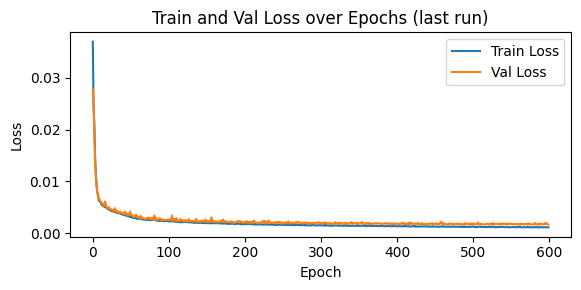

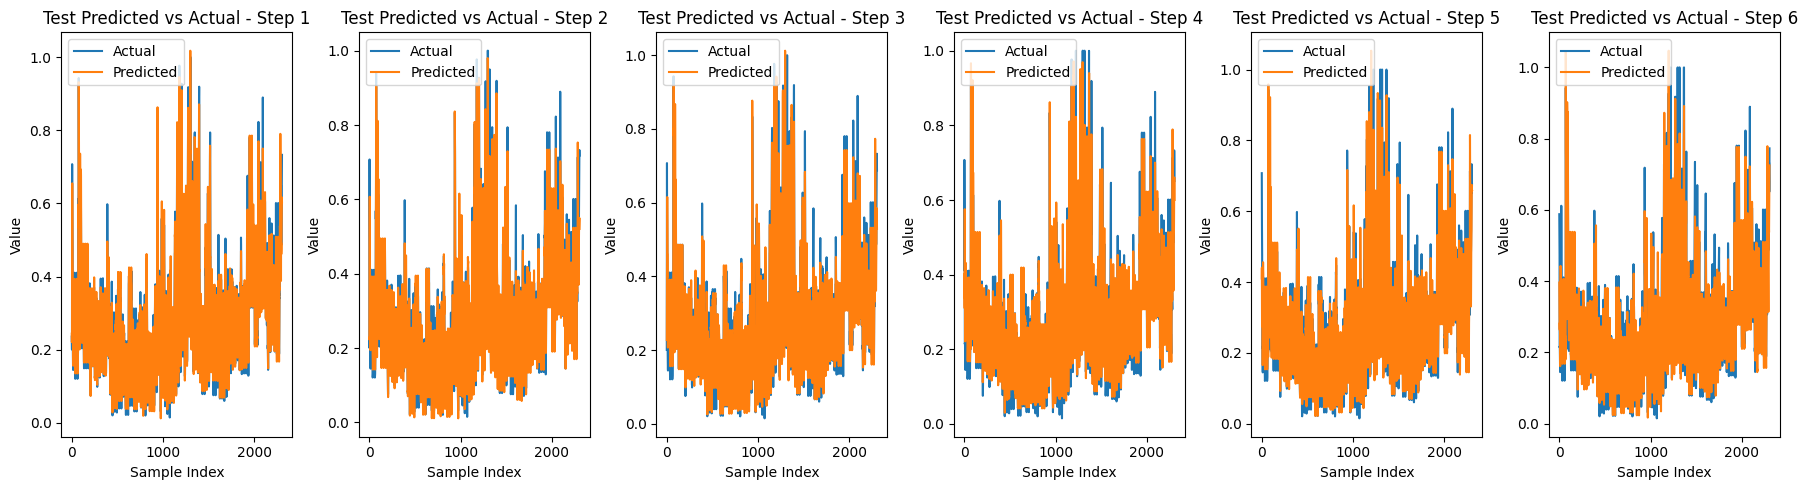

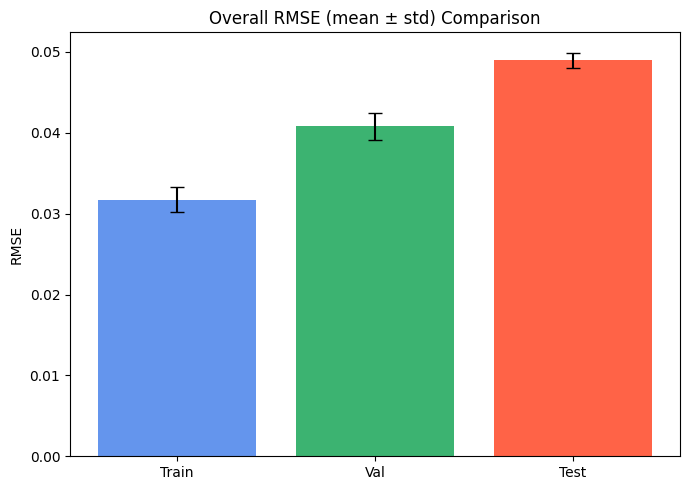

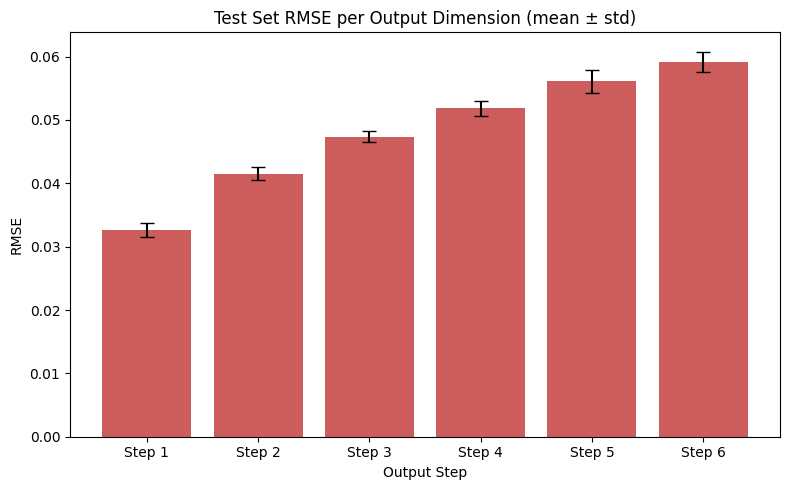

In [4]:
import matplotlib.pyplot as plt
import numpy as np

train_mse_all = np.array(train_mse_all)                     # (runs,)
val_mse_all = np.array(val_mse_all)                         # (runs,)
test_mse_per_output_all = np.array(test_mse_per_output_all) # (runs, output_dim)
test_mse_total_all = np.array(test_mse_total_all)           # (runs,)

# ============ MSE/RMSE & STD ============
train_mse_mean = train_mse_all.mean()
train_mse_std = train_mse_all.std()
val_mse_mean = val_mse_all.mean()
val_mse_std = val_mse_all.std()

train_rmse_all = np.sqrt(train_mse_all)
val_rmse_all = np.sqrt(val_mse_all)
test_rmse_all = np.sqrt(test_mse_total_all)

train_rmse_mean = train_rmse_all.mean()
train_rmse_std = train_rmse_all.std()
val_rmse_mean = val_rmse_all.mean()
val_rmse_std = val_rmse_all.std()
test_rmse_mean = test_rmse_all.mean()
test_rmse_std = test_rmse_all.std()

# ============ print results ============
print("Final Results (mean ± std over runs):")
print(f"Train Total MSE: {train_mse_mean:.6f} ± {train_mse_std:.6f} | RMSE: {train_rmse_mean:.6f} ± {train_rmse_std:.6f}")
print(f"Validation Total MSE: {val_mse_mean:.6f} ± {val_mse_std:.6f} | RMSE: {val_rmse_mean:.6f} ± {val_rmse_std:.6f}")
print(f"Test Total MSE: {test_mse_total_all.mean():.6f} ± {test_mse_total_all.std():.6f} | RMSE: {test_rmse_mean:.6f} ± {test_rmse_std:.6f}")

output_dim = test_mse_per_output_all.shape[1]

for i in range(output_dim):
    print(f"Test Output {i+1} MSE: {test_mse_per_output_all[:, i].mean():.6f} ± {test_mse_per_output_all[:, i].std():.6f}")

test_rmse_per_output_all = np.sqrt(test_mse_per_output_all)
for i in range(output_dim):
    print(f"Test Output {i+1} RMSE: {test_rmse_per_output_all[:, i].mean():.6f} ± {test_rmse_per_output_all[:, i].std():.6f}")

# ============ plot(last fold) ============
# last_train_losses, last_val_losses:
plt.figure(figsize=(6, 3))
plt.plot(last_train_losses, label='Train Loss')
plt.plot(last_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss over Epochs (last run)')
plt.legend()
plt.tight_layout()
plt.show()

# predicted vs actual
plt.figure(figsize=(18, 5))
for i in range(output_dim):
    plt.subplot(1, output_dim, i + 1)
    plt.plot(y_true_test_final[:, i], label='Actual')
    plt.plot(y_pred_test_final[:, i], label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'Test Predicted vs Actual - Step {i+1}')
    plt.legend()
plt.tight_layout()
plt.show()

# RMSE comparison
train_final_rmse = train_rmse_all.mean()
val_final_rmse = val_rmse_all.mean()
test_final_rmse = test_rmse_all.mean()

plt.figure(figsize=(7, 5))
plt.bar(['Train', 'Val', 'Test'],
        [train_final_rmse, val_final_rmse, test_final_rmse],
        yerr=[train_rmse_std, val_rmse_std, test_rmse_std],
        capsize=5, color=['cornflowerblue', 'mediumseagreen', 'tomato'])
plt.ylabel('RMSE')
plt.title('Overall RMSE (mean ± std) Comparison')
plt.tight_layout()
plt.show()

# RMSE across steps
rmse_means = test_rmse_per_output_all.mean(axis=0)
rmse_stds = test_rmse_per_output_all.std(axis=0)
steps = [f'Step {i+1}' for i in range(output_dim)]

plt.figure(figsize=(8, 5))
plt.bar(steps, rmse_means, yerr=rmse_stds, capsize=5, color='indianred')
plt.xlabel('Output Step')
plt.ylabel('RMSE')
plt.title('Test Set RMSE per Output Dimension (mean ± std)')
plt.tight_layout()
plt.show()
